# Grokking pytorch notes

Notes on [Grokking pytorch](https://github.com/Kaixhin/grokking-pytorch) and the [official MNIST example](https://github.com/pytorch/examples/blob/master/mnist/main.py), MLW, 2018-08-24

## Command line scripts

```python
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--save-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before checkpointing')
parser.add_argument('--resume', action='store_true', default=False,
                    help='resume training from checkpoint')
args = parser.parse_args()
```

Device-independent prelude.

```python
use_cuda = torch.cuda.is_available() and not args.no_cuda
device = torch.device('cuda' if use_cuda else 'cpu')

```

 You may need to set more seeds (e.g. numpy, scikit-learn) for determinism (and even then...)

```python
torch.manual_seed(args.seed)
if use_cuda:
  torch.cuda.manual_seed(args.seed)
```

## DataLoader

Author of grokking pytorch stores torchvision datasets (and others?) under `~/.torch/datasets`.

We've already seen the batch_size and shuffle options of DataLoader.

The other ones worth knowing about are `num_workers` which loads data asynchronously if `> 0`, and `pin_memory` which makes no difference to CPU code, but keeps the dataset in long term "pinned" on the GPU for a speedup ([I think](https://pytorch.org/docs/master/notes/cuda.html#use-pinned-memory-buffers)).

In [1]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader


data_path = os.path.join(os.path.expanduser('~'), '.torch', 'datasets', 'mnist')

train_data = datasets.MNIST(data_path, train=True, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]))
test_data = datasets.MNIST(data_path, train=False,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))

train_loader = DataLoader(train_data, batch_size=64,
                          shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64,
                         num_workers=4, pin_memory=True)

In [2]:
len(train_data), len(test_data)  # samples

(60000, 10000)

In [3]:
len(train_loader), len(test_loader)  # batches

(938, 157)

## MNIST model


Network initialisation typically includes member variables, layers which contain trainable parameters, and maybe separate trainable parameters and non-trainable buffers.

The forward pass then uses these in conjunction with functions from `F` that are purely functional (don't contain parameters).

According to grokking pytorch "Some people prefer to have completely functional networks (e.g., keeping parameters separately and using `F.conv2d` instead of `nn.Conv2d`) or networks completely made of layers (e.g., `nn.ReLU` instead of `F.relu`)." I'm not sure how that works.

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

It's important to transfer the network parameters to the appropriate device before passing them to the optimiser, otherwise the optimiser will not be keeping track of the parameters properly!

I.e. this line...

In [7]:
model = Net().to(device)

...comes before this one...

In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

model and optimizer can load and save themselves. You're supposed to [save these state_dicts](https://pytorch.org/docs/stable/notes/serialization.html) using the helper methods rather than the entire model.

In [9]:
args_resume=False

if args_resume:
  model.load_state_dict(torch.load('model.pth'))
  optimizer.load_state_dict(torch.load('optimizer.pth'))

Network modules are by default set to training mode - which impacts the way some modules work, most noticeably dropout and batch normalisation. It's best to set this manually anyway with `.train()`, which propagates the training flag down all children modules.

In [10]:
model.train()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Train over a single epoch

In [12]:
train_losses = []

for i, (data, target) in enumerate(train_loader):
    # Move batch to device
    data, target = data.to(device), target.to(device)

    # Before collecting a new set of gradients with loss.backward() and doing 
    # backpropagation with optimiser.step(), it's necessary to manually zero 
    # the gradients of the parameters being optimised with optimiser.zero_grad()
    optimizer.zero_grad()
    output = model(data)
    
    # Negative log likelihood loss
    loss = F.nll_loss(output, target)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()

    # Checkpoint every 100 batches
    if i % 100 == 0:
        print(i, loss.item())
        torch.save(model.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimiser.pth')
        torch.save(train_losses, 'train_losses.pth')

0 2.304744005203247
100 1.500756025314331
200 0.3390892446041107
300 0.5793246030807495
400 0.34322935342788696
500 0.45604729652404785
600 0.18978355824947357
700 0.1186731681227684
800 0.20617105066776276
900 0.34539681673049927


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

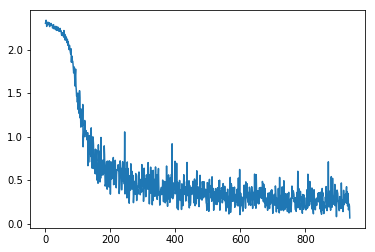

In [15]:
plt.plot(train_losses);

To evaluate, explicitly set to evaluation mode, e.g. disable dropout and batchnorm

In [16]:
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [30]:
def test():
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Accumulate loss
            test_loss += F.nll_loss(output, target, reduction="sum").item()

            # # keepdim=True makes the pred a 16x1 2d Tensor
            # pred = output.argmax(1, keepdim=True)
            # # which means we need to do view_as to reshape it to the same shape as pred (i.e. 16-element 1d Tensor)
            # correct += pred.eq(target.view_as(pred)).sum().item()

            # simpler to do
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()

    test_loss /= len(test_data)
    acc = correct / len(test_data)
    print("Accuracy:", acc)
    print("Avg loss on test set:", test_loss)
    
test()

Accuracy: 0.9753
Avg loss on test set: 0.07690166027545929


Now train for several epochs

In [33]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []

for epoch in range(1, 4):
    model.train()
    for i, (data, target) in enumerate(train_loader):
        # Move batch to device
        data, target = data.to(device), target.to(device)

        # Before collecting a new set of gradients with loss.backward() and doing 
        # backpropagation with optimiser.step(), it's necessary to manually zero 
        # the gradients of the parameters being optimised with optimiser.zero_grad()
        optimizer.zero_grad()
        output = model(data)

        # Negative log likelihood loss
        loss = F.nll_loss(output, target)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

        # Checkpoint every 100 batches
        if i % 100 == 0:
            torch.save(model.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimiser.pth')
            torch.save(train_losses, 'train_losses.pth')
    model.eval()
    test()

Accuracy: 0.9522
Avg loss on test set: 0.15608287732601167
Accuracy: 0.9685
Avg loss on test set: 0.09415596387386323
Accuracy: 0.9782
Avg loss on test set: 0.06888121318817139
